# Bed separation from absolute locations

To quantify the amount of vertical bed separation occurring as a result of cavity formation at the glacier bed, we follow the analyzes of Iken and Bindschadler (1986), Harper et al. (2007) and Howat et al. (2008). Surface elevation (z) change with respect to time is the sum of bed separation (s) change with respect to time, elevation change due to advection at velocity u along bed slope $\beta$ and depth-averaged vertical strain rate of the mean ice thickness H:

\begin{equation}
    \frac{d z}{d t} = \frac{d s}{d t}  + u \tan \beta + \langle \dot{\epsilon}_{zz} \rangle H
\end{equation}

# INCOMPLETE

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from numpy import linalg as LA
from functools import reduce
import os
import sys
import time
import datetime 
import pandas as pd

from shapely.geometry import Point
import fiona

sys.path.append(os.path.abspath('/Users/home/whitefar/DATA/code/'))
os.chdir("/Users/home/whitefar/DATA/TASMAN/ABSOLUTE/")

In [239]:
#with only the site_units that have data over the time period
site_units = ['tal1arc2', 'tal2arc1', 'tac2arc5', 'tac3arc4', 'tar2arc6']

dfs = {}  #dataframes

for siteunit in site_units:
    dfs[siteunit] = pd.read_pickle(f"/Volumes/arc_04/whitefar/DATA/TASMAN/GNSS_ABSOLUTE/GNSS_dataframe/{siteunit}_moreattributes.pkl")

In [240]:
dfs['tal1arc2'].head()

,Timestamp,site,unit,Year,DOY,Seconds,Latitude,Longitude,Height,SigN,...,DOY.1,Epoch,#BF,NotF,Points,distance,datetime,dt,velocity,velocityangle
0,1.462018e+09,tal1,arc2,2016,122,0,-43.648040,170.200913,825.1834,2.5,...,1.0,14,0,K,POINT (1374258.988 5163409.886),0.000000,2016-05-01 00:00:00,NaN,NaN,NaN
1,1.462018e+09,tal1,arc2,2016,122,30,-43.648039,170.200913,825.1811,2.5,...,2.0,14,0,S,POINT (1374258.989 5163409.907),0.020453,2016-05-01 00:00:30,30.0,21515.211207,1.497801
2,1.462018e+09,tal1,arc2,2016,122,60,-43.648039,170.200913,825.1828,2.5,...,3.0,14,0,S,POINT (1374258.983 5163409.903),0.007733,2016-05-01 00:01:00,30.0,8134.031285,-2.564068
3,1.462018e+09,tal1,arc2,2016,122,90,-43.648039,170.200913,825.1829,2.5,...,4.0,14,0,S,POINT (1374258.991 5163409.898),0.008932,2016-05-01 00:01:30,30.0,9395.406115,-0.487202
4,1.462018e+09,tal1,arc2,2016,122,120,-43.648039,170.200913,825.1756,2.5,...,5.0,14,0,S,POINT (1374258.991 5163409.902),0.004116,2016-05-01 00:02:00,30.0,4329.941965,1.367049


# Calc velocity

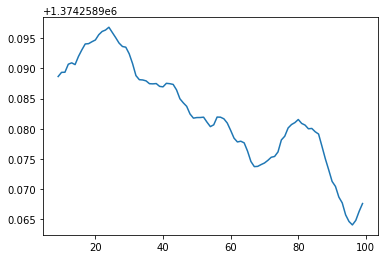

In [241]:
plt.plot(dfs['tal1arc2'].geometry.x.rolling(window=10).mean().iloc[:100])

In [278]:
def smooth_geometry(gdf,window):
    
    gdf['x_smoothed'] = gdf.geometry.x.rolling(window=window).mean()
    gdf['y_smoothed'] = gdf.geometry.y.rolling(window=window).mean()
    
    gdf['geometry_smooth'] = pd.Series([Point(x,y) for x,y in zip(gdf.x_smoothed,gdf.y_smoothed)])
    gdf.set_geometry('geometry_smooth',inplace=True)
    gdf.drop('DDiff',axis=1,inplace=True)

    gdf.dropna(inplace=True)
    gdf.reset_index(drop=True,inplace=True)

def add_distance_to_gdf(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dx' and 'distance_cum' to the geodataframe
    """
    tmp_dfp = [Point.distance(gdf.geometry_smooth.iloc[i]) for i,Point in enumerate(gdf.geometry_smooth.iloc[1:])] #note the 1:, equivalent to i+1
    tmp_dfp[:0] = [0]
    gdf['dx'] = pd.Series(tmp_dfp) 
    gdf['distan_cum'] = gdf.dx.cumsum().copy()   
    
def add_velocity(gdf):
    """
    Input: geodataframe
    Output: Adds columns velocity in m / s
    """
    gdf['velocity'] = gdf.dx / gdf.Timestamp.diff()
    gdf['velocity'] = gdf.velocity.rolling(window=window).mean().copy()
#     gdf.dropna(inplace=True)

def smooth_height(gdf,window):
    gdf['Height'] = gdf.Height.rolling(window=window).mean().copy()



In [279]:
dfz = dfs.copy()
window = 300 #30 second dt so window=10 is 5 mins

# su is siteunit
for su, df in dfz.items():
    

    smooth_geometry(df,window)
    smooth_height(df,window)
    add_distance_to_gdf(df)
    add_velocity(df)
#     df[df.velocity.isna()] = 0

KeyError: "['DDiff'] not found in axis"

# define the speed up events

In [280]:
su = 'tal2arc1'

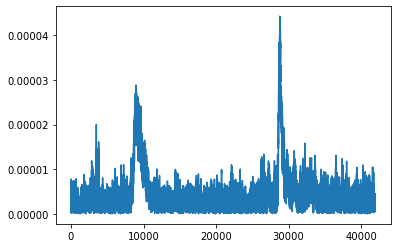

In [281]:
plt.plot(dfz[su].velocity)

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


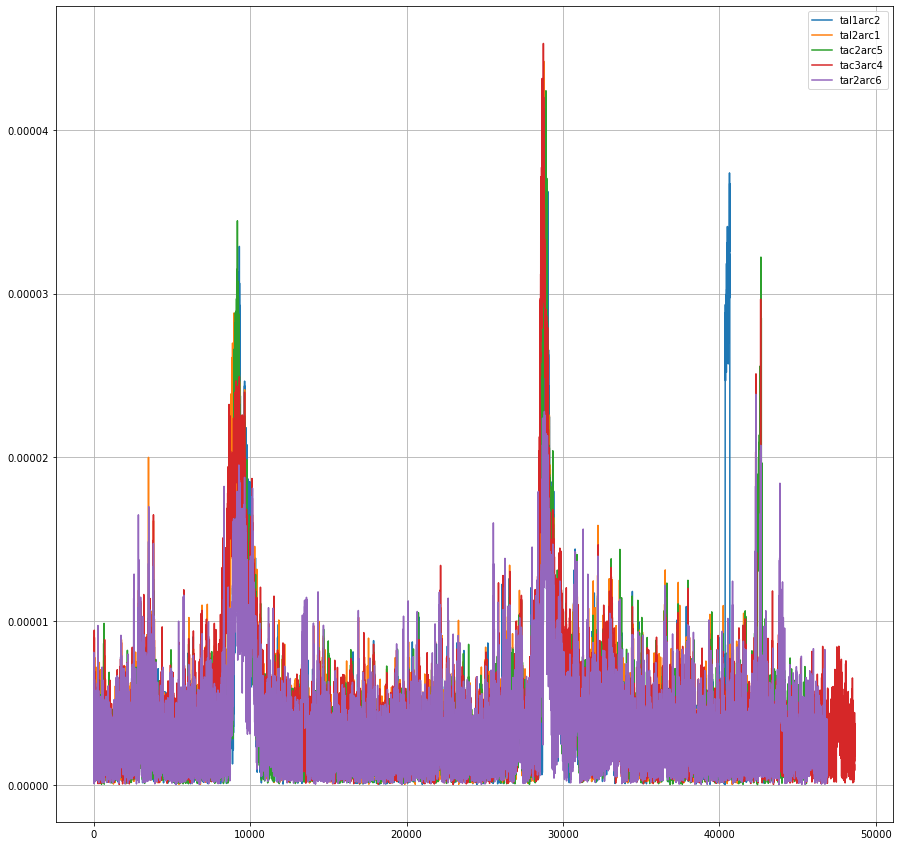

In [282]:
plt.figure(figsize=(15,15))
for df in dfz:
     plt.plot(dfz[df].velocity)
plt.legend(dfs.keys())
plt.grid()
plt.show()

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


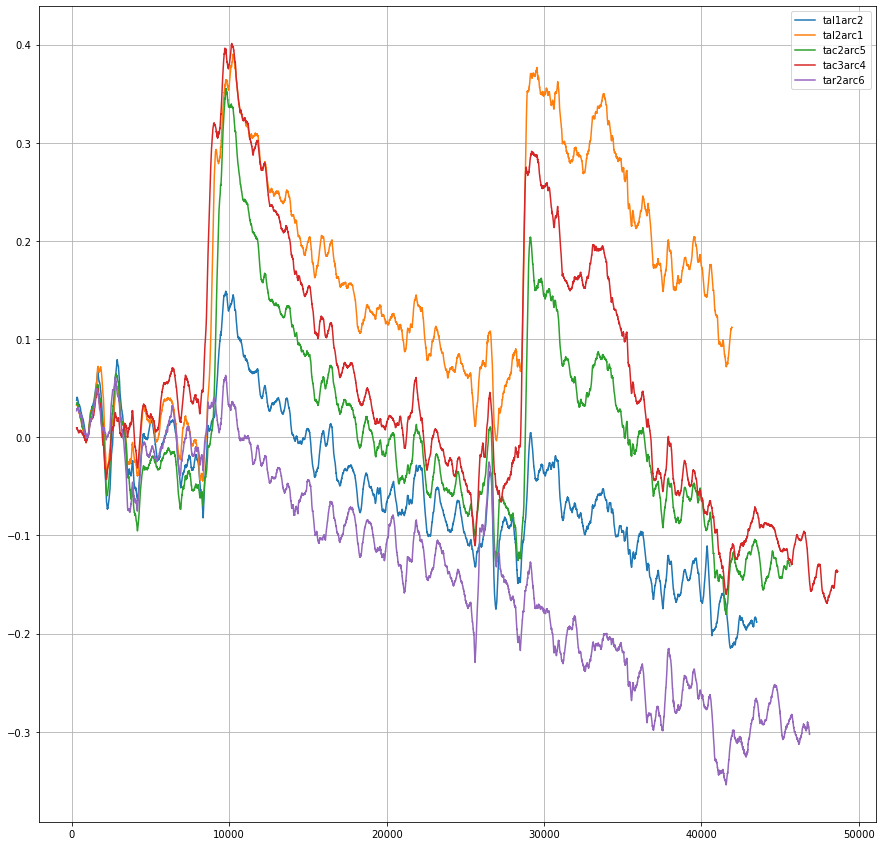

In [314]:
plt.figure(figsize=(15,15))
for df in dfz:
     plt.plot(dfz[df].Height-float(dfz[df].Height.iloc[1000]))
plt.legend(dfs.keys())
plt.grid()
plt.show()

In [306]:
df = 'tal2arc1'
float(dfz[df].Height.iloc[-1])

864.2839593333338

In [283]:
df_speed_indicies = dfz[su][dfz[su].velocity > 0.0001].index
df_speed_indicies

Int64Index([], dtype='int64')

In [296]:
df_speed = dfz[su].loc[8000:28000].copy()

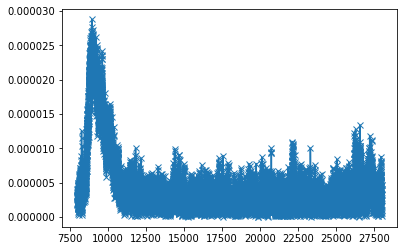

In [297]:
plt.plot(df_speed.velocity,'x-')

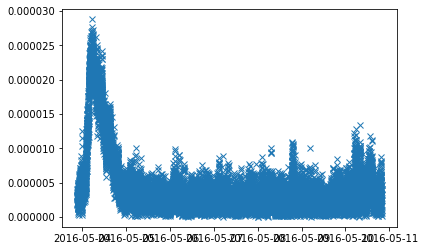

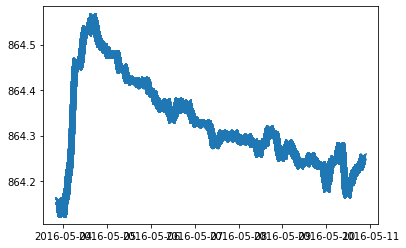

In [298]:
plt.plot(df_speed.datetime,df_speed.velocity,'x')
plt.figure()
plt.plot(df_speed.datetime,df_speed.Height,'x')

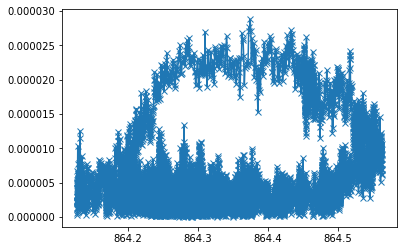

In [299]:
plt.plot(df_speed.Height,df_speed.velocity,'x-')

# Bed slope

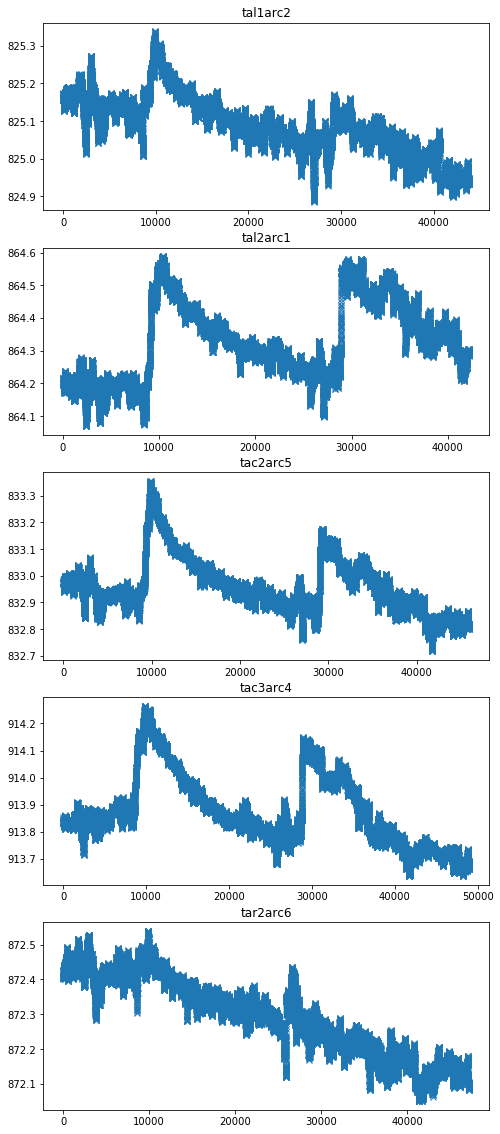

In [188]:
fig, axs = plt.subplots(5,1,figsize=[8,20])
for i,df in enumerate(dfs):
    axs[i].plot(dfs[df].Height.rolling(window=20).mean(),'x')
    axs[i].set_title(df)

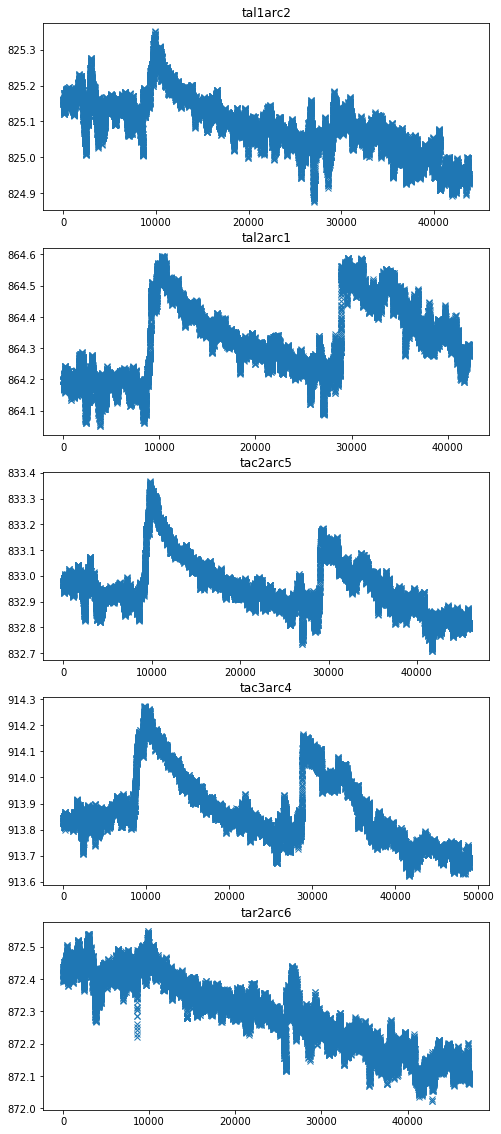

In [177]:
fig, axs = plt.subplots(5,1,figsize=[8,20])
for i,df in enumerate(dfs):
    axs[i].plot(dfs[df].Height.rolling(window=10).mean(),'x')
    axs[i].set_title(df)